In [48]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error 


import statsmodels.api as sm

# Introduction

Machine Learning (ML) has been receiving lots of attention in the fields of computer vision, artifical intelligence, medicine, and many others. However, with so many different approaches, opinions, models, and on going research in this rapidly developing field, it can feel overwhelming first entering the field. In the earth sciences, we are primarily concerned with discovering how the natural world operates and the forces that are involved in the shaping it. While ML is a powerful prediction tool, little has been done to implement it has a tool for discovery in the earth sciences. This is primarily due to many of the top performing ML algorithms being difficult to interpret intuitively and even mathematically.

Fortunately, the field of *Explainable AI (XAI)* concerns itself with exactly what we seek as earth scientists: how are these ML models making predictions and what do they mean about the processes we seek to approximate?

Here, we walk through how to use an interpretable ML model, use a more difficult to interpret ML model, then apply a post-training explainability technique, specifically using a python package called *SHAP*, to better understand how our ML models are making predictions. Starting from simple examples using only two predictive variables, we will examine *Shapely values* (explanation below) to get a better understanding of how they work and how we can apply them.


## Scientific Motivation

Sediment builds our coastlines, is crucial for agriculture, and stores natural resources. However, it is incredible dynamic, constantly being removed, transported, and redeposited. Sediment is always on the move and, due to this, it can be difficult to determine where it will be deposited next. 

Using an unprecendented dataset of coastal marsh sedimentation rates derived from the Coastal Reference Monitoring System (CRMS), we want to discern the driving environmental factors related to sedimentation, as recorded by *vertical accretion rate*. Vertical accretion rate in our dataset is recorded as the height of sediment deposited above a datum which is then temporally averaged across 16 years, the total amount of time the CRMS dataset encapsulates. It records the sedimentation processes that build our coastlines, balancing land lose with land gain. Coastal Louisiana is no stranger to this delicate balance of inputs and outputs. Louisiana's sediment budget has been diminshed by upstream damming and the leveeing of the river systems, amplifying land loss across the coast. The saying in coastal Louisiana is that we lose about an american football field worth of land every **hour**! This makes it imperative to constrain the drivers of vertical accretion so that we can sustainably manage the coast. 

Complementing vertical accretion rate measurements, the CRMS dataset provides additional biologic, hydrologic, and sedimentologic variables (TABLE 1). Because marsh sedimentation consists of two parts, an organic and mineral sediment component, there are many variables contributing to vertical accretion and complex dynamics between those variables. We want to use a statistical framework to first identify the most salient features, then use a ML model to make predictions of vertical accretion rate and understand how to our predictor variables are able to capture the process of vertical accretion rate.

All the data we use it openly available online with descriptions:

CRMS: https://www.lacoast.gov/chart/Charting.aspx?laf=crms&tab=2                       
CIMS: https://cims.coastal.louisiana.gov/monitoring-data/ 

## Brief Data Descriptions

In [49]:
url = "https://raw.githubusercontent.com/geo-smart/XAI_coastalLA/main/ESIP_dataset3.csv" # Make sure the url is the raw version of the file on GitHub
df = pd.read_csv(url)
print(df.columns) # lets see what variables we are working with

Index(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)',
       'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)',
       'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)',
       'Log Distance to Water (km)', 'Log Distance to River (km)',
       'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)',
       '10th Percentile Flood Depth (cm)', 'Std. Deviation Flood Depth (cm)',
       'Avg. Flood Depth (cm)', 'Community', 'Longitude', 'Latitude',
       'Organic Matter (%)', 'Bulk Density (g/cm3)'],
      dtype='object')


In [50]:
# lets know how many variables and how many samples we have to work with
print("Number of samples in dataset: ", len(df))
print("Number of features in the dataset: ", len(df.columns) )

Number of samples in dataset:  208
Number of features in the dataset:  21


In [51]:
# There are some unnecessary and/or uninformative variables in here, so lets remove them
df = df.drop([
    'Longitude', 'Latitude', 'Bulk Density (g/cm3)', 'Organic Matter (%)'
], axis=1)

I removed the variables: longitude, latitude, bulk density (g/cm3), and organic matter (%) because they do not provide us with an associated transport or biologic process such as flooding, biomass production, biomass decay, erosion, etc. Latitude and longitude are only geographic descriptions of where sites are, making them uninformative towards a process understanding of vertical accretion. While bulk density and organic matter (%) are descriptions of the soil that has already been deposited, rather than *how* it might have been deposited.

In [52]:
outcome = 'Accretion Rate (mm/yr)'
feature_ls = list(df.columns.values[1:-1]) # make a list including all the variables; excluding the categorical Site and Maarsh community variables
print(feature_ls) # looks good; great!

['Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)', 'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)', 'Log Distance to Water (km)', 'Log Distance to River (km)', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)', '10th Percentile Flood Depth (cm)', 'Std. Deviation Flood Depth (cm)', 'Avg. Flood Depth (cm)']


## Variable Descriptions

The remaining variables that will be used in the analysis are: 
* **Accretion Rate (mm/yr)**: The amount of sediment deposited above a datum. Recorded with a 6 to 18 month sampling period.
* **Soil Porewater Salinity (ppt)**: The ppt measured from a syringe inserted into the soil. Recorded variably to annually.
* **Average Height Dominant (cm)**: Survey measurement of the average hieght of the dominant vegetation species. Sampled annually. 
* **NDVI**: The Normalized Difference Vegetation Index which is an estimate of aboveground biomass from Landsat 7. Samples consisted of an 8 day averages only collected during the months of peak biomass, July-August.
* **TSS (mg/l)**: Estimate of Total Suspended Sediment (TSS) from MODIS. With a 2-day sampling (recurrance) interval.
* **Windspeed**: Reanalysis data from the Global Wind Atlas availible from Google Earth Engine (GEE).
* **Tidal Amplitude (cm)**: The average daily difference between the highest recorded and lowest hourly waterlevel.
* **Average Time Flooded (%)**: The percentage of time in which the waterlevel exceeds the elevaation of the marsh. Calculated from hourly waterlevel measurements.
* **Flood Frequency (Floods/yr)**: The number of times that the waterlevel exceeds the elevation of the marsh. Calculated from hourly waterlevel measurements.
* **Average Flood Depth (cm)**: The average waterlevel when the waterlevel is higher than the marsh elevation. Calcualted from hourly waterlevel measurements. 
* **90th Percentile Flood Depth (cm)**: The 90th percentile of the timeseries distribution of average flood depth. Calculated from hourly waterlevel measurements.
* **10th Percentile Flood Depth (cm)**: The 10th percentile of the timeseries distribution of average flood depth. Calculated from hourly waterlevel measurements.
* **Std. Deviation Flood Depth (cm)**: The standard deviation of the timeseries distribution of average flood depth. Calcualted from hourly waterlevel measurements. 
* **Log Distance to Water (km)**: The log of the distance to the nearest water pixel (90% recurrence). 
* **Log Distance to River (km)**: The log of the distance to the nearest GRWL river vector taken from GEE. 
* **Community**: Marsh Community (Freshwater, Intermediate, Brackish, Saline, Swamp) determined from surveys of                        vegetation and salinity gradients.

Note that all of these variables spanned either the lifespan of a CRMS site which largely encapsulates 2007 to 2022. 

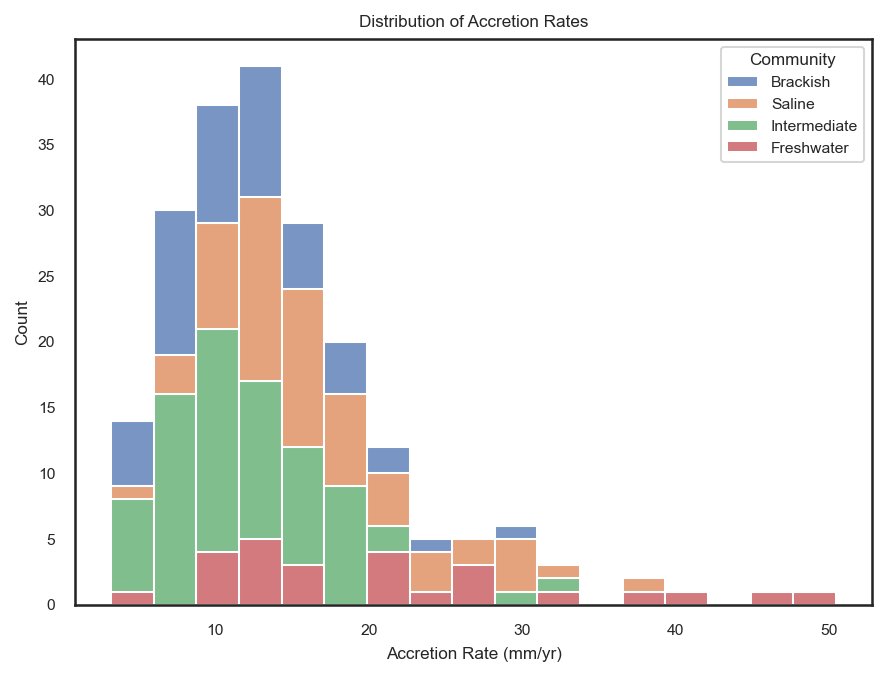

In [53]:
# Lets visualize what we want to predict, 'Accretion Rate (mm/yr)'
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(1, 1, 1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Accretion Rate (mm/yr)", kde=False,
             hue="Community",
             element="bars", legend=True)
ax.set_title("Distribution of Accretion Rates")
ax.set_xlabel("Accretion Rate (mm/yr)")
ax.set_ylabel("Count")
plt.show()

In [54]:
# lets define our target and design matrix for our ML job
target = df[outcome]
phi = df.drop(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Community'], axis=1)

In [55]:
target.describe()

count    208.000000
mean      14.544686
std        7.679710
min        3.208008
25%        9.684788
50%       12.701547
75%       18.200853
max       50.425133
Name: Accretion Rate (mm/yr), dtype: float64

In [56]:
phi.describe()

,Soil Porewater Salinity (ppt),Average Height Dominant (cm),NDVI,TSS (mg/l),Windspeed (m/s),Avg. Time Flooded (%),Flood Freq (Floods/yr),Log Distance to Water (km),Log Distance to River (km),Tidal Amplitude (cm),90th Percentile Flood Depth (cm),10th Percentile Flood Depth (cm),Std. Deviation Flood Depth (cm),Avg. Flood Depth (cm)
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,7.488726,109.645313,0.345306,33.776169,6.714686,42.729742,163.631107,0.166635,2.974625,11.507986,29.304439,0.657840,13.493443,12.320192
std,5.919844,21.135709,0.108436,10.845693,0.248734,24.813103,109.303101,1.027612,1.067866,9.183479,9.156496,2.155759,2.801808,6.099182
min,0.200000,54.860000,0.099034,0.000000,5.989133,0.000000,0.000000,-3.534766,-1.828729,0.060442,8.424672,0.000000,5.361793,2.454536
25%,2.500000,96.770000,0.282428,28.675858,6.548332,25.715094,63.564421,-0.223163,2.451048,1.866514,23.483316,0.000000,11.373617,7.890813
50%,5.800000,106.800000,0.350556,32.980339,6.742525,45.308426,163.274714,0.000000,3.259573,11.038231,29.001720,0.000000,13.288951,11.037287
75%,12.000000,120.700000,0.388779,40.282164,6.890631,59.509360,249.619152,0.947898,3.808251,20.102054,34.839402,0.000000,15.571800,15.539290
max,24.500000,190.800000,0.627081,58.441428,7.315856,99.965846,534.000000,2.084955,4.305684,27.500165,56.144160,14.782800,20.273093,30.990717


# Interpretable Models

Every machine learning model is interpretable in some way or another, however, simpler models are much easier to interpret. Many top performing models, such as Artifical Neural Networks, Convolutional Neural Networks, and ensemble models such as Random Forests are not easily interpretable mathematically and can often disencourage scientist who seek to use them for discovery scientific relationships rather than prediction. But, there are also less popular but equally well performing models that are also interpretable out there. We will discuss two types of models, a Bayesian Linear Regresison and a Gaussian Process Regression, that have analytical solutions for the conditional probability of our target variable and are able to reproduce the complex dynamics of the unknown function we are trying to approximate. 


## Bayesian Linear Regression

A Bayesian Linear Regression (BLR) is one of the most interpretable machine learning models to implement. The BLR’s approximation of the unknown function $f(x)$ is composed from a linear combination of the input features, $x$, such that:
$$f(x,w)= \sum^N_{i=1} w_i x_i $$
Equation 1

where $w$ is the unknown parameter known as the weight vector, $N$ is the number of predictors or columns in the design matrix, and $x$ are the input features. A more familiar writing of the above equation can look like: 
$$ y=w_0+w_1 x_1+⋯+w_n x_n $$
Equation 2

Given that the BLR has an analytical solution to the conditional probability of our target variable, the same inputs we will always find the same predicted probabilities of vertical accretion (Bishop 2006). This is preferable from a scientific perspective when making conclusions from the learned weight parameters and building confidence in our model’s predictions. Model uncertainty quantification can be readily attained using the Bayesian treatment of linear regression through the standard deviation of the predictive distribution and from the eigen decomposition of the design matrix (Bishop 2006, MacKay 1992).

We make use of an L2 regularized term that can be added to the BLR to mitigate the effect of overfitting the data. The regularization term can be solved for during the training phase through the technique called Empirical Bayes rather than through hyperparameter tuning with cross validation (Supplementary for derivation ??) (Bishop 2006, Mackay 1992). Our solution to find the weight vector then follows the regularized least squares solution (Bishop).
$$ p(w│y,X)= \frac{\beta}{2} \sum_{i=1}^N(y_i - w^T \phi(x_i ))^2 - \frac{\alpha}{2} w^T w $$
Equation 3

Where $\beta$ is the noise parameter over y, the target variable from the train set, and $\alpha$ is the precision over the weight parameter. $X$ is the data in the design matrix.



## Gaussian Process Regression

The GPR begins with our desire to find an unknown function $f(x)$ that will help us predict our target variable $y$ with the addition of some Gaussian distributed noise, $\epsilon$, such that:
$$ y = f(x)+ \epsilon $$
Equation 4

The BLR approach falls short when the relationship between our input and output variables is nonlinear, due to defining our unknown function as a linear combination of the predictors governed by the learned weight parameter, $w$ (Eq. 1). A Gaussian Process Regression (GPR) overcomes the limited flexibility of the BLR by projecting the inputs into an infinitely high dimensional space using a set of basis functions, $\phi(x)$, which allows us to overcome the assumption of linearity in a BLR (Rasmussen and Williams 2005). This makes GPR a powerful non-parametric machine learning model that can capture the nonlinear dynamics and interactions of the input and output variables. 

The reasoning behind a GPR includes using a Gaussian process to describe the distribution over all possible functions for a given sample $x_i$. Defined as a collection of random variables of which any finite set have a joint Gaussian distribution, a Gaussian process can be completely specified by its mean function, $m(x)$, and covariance function, $k(x,x')$ (Rasmussen and Williams 2005). With a known mean and covariance, we can write the prior distribution of all possible random unknown functions as:
$$ f(x)∼GP(m(x),k(x,x')) $$
Equation 5

An important choice for the investigator is choosing the covariance function, $k(⋅,⋅)$, for the GPR model that best describes our data. In broad sense, we expect similar samples to have similar outcomes and effects on the target variable and covariance function is what defines the similarity between samples. After multiple trials, we deduce that a squared dot product covariance function fits our data best.  
$$ k(x,x' )=(x \cdot x' )^2+\delta$$
Equation 6

Where $\delta$ is the error associated with the target variable and $x$ and $x'$ are predictors.  

From a specified mean and covariance function, the computation of the conditional probability of our target is straight forward. Assuming a $0$ mean we can write:

$$\begin{bmatrix} y \\ f_* \end{bmatrix} = \mathcal{N} ( \begin{bmatrix} 0 \\ 0 \end{bmatrix} , \begin{bmatrix} (k(X,X)+σ^2I & k(X,X_*) \\ k(X_*,X) & k(X_*,X_*) \end{bmatrix} )$$
Equation 7

Where $k(X,X)$ is the covariance between training samples, $k(X_*,X_*)$ is the covariance between testing samples, $k(X_*,X)$ and $k(X,X_*)$ are the covariances between training and testing samples, $y$ is the target variable, $f_*$ is the learned function, and $\sigma^2$ is the noise associated with the target variable (Rasmussen and Williams 2005). Utilizing the rules for the combination of partitioned Gaussians we can write the mean and covariance for the predictive distribution as
$$ m(x)=k(X_*,X)(k(X,X)+ σ^2 I)^{-1} y $$
Equation 8

$$ k(x,x') = k(X_*,X_* ) - k(X_*, X)(k(X,X)+ σ^2 I)^{-1} k(X,X_*) $$
Equation 9


# Linear Regression

A linear regresison is a parametric machine learning model, which means that we assume the function that we want to approximate. In a linear regression this assumption is linear. Due to simplicity of linear functions, extracting the notable linear relationships is a great first order approximation due to their interpretability. It also provides a baseline model to compare against as we increase our model complexity. 

First, we are going to show that both the Ordinary Least Squares and Bayesian Linear Regression learn the same parameters given the same data and perform similarly. While they execute the same predicted probabilities, there are some inherent model characteristics of the Bayesian linear regression that are easy to directly interpret and my be preferable to some investigators.

The solution for the learned weight vector for the Ordinary Least Squares (OLS) Ridge Regression 

The solution for the learned weight vector for the Bayesian Ridge Regression follows:

In [57]:
# Scaling 
scalar = StandardScaler()
data = pd.DataFrame(scalar.fit_transform(phi), columns=phi.columns.values)

In [58]:
# Testing whether the scikit learn ridge and bayesian ridge learn the same paramters
olsr = linear_model.Ridge()
br = linear_model.BayesianRidge()

# We need to hyperparamter tune the OLS Ridge because there is no way to solve for the regularization parameter analytically
searcher = GridSearchCV(olsr, {'alpha': np.arange(1, 300, 2)}, scoring="neg_root_mean_squared_error")
searcher.fit(data[['Tidal Amplitude (cm)', 'Avg. Flood Depth (cm)']], target)
best_olsr = searcher.best_estimator_
print("Best regularizor by Cross Validation: ", searcher.best_params_)
print("Learned Weight Coefficents: ", best_olsr.coef_)

Best regularizor by Cross Validation:  {'alpha': 1}
Learned Weight Coefficents:  [4.52025369 2.02483088]


In [59]:
# fit the br and see if it is the same
br.fit(data[['Tidal Amplitude (cm)', 'Avg. Flood Depth (cm)']], target)
print("Learned Regularizor: ", br.lambda_ / br.alpha_)
print("Learned Weight Coefficent: ", br.coef_)

Learned Regularizor:  3.4382869689262567
Learned Weight Coefficent:  [4.44840761 1.97374723]


From the weight coefficents and learned regularizors, we can see that the two methods produce similar results. While the only difference arises from the learned regularization term. We are able to find the Bayesian Ridge Regression solves for a higher regularization term of 3.44 through the Empirical Bayes method, while the cross-validation of the OLS Ridge Regression finds an optimal regularization term value of 1. 

Notice the computational difference between the two methods. The solution for the hyperparamters of the Bayesian linear regression model using Empirical Bayes is more efficent than using cross validation to find the optimal regularization term in the OLS Ridge model. Addtionally, when hyperparamter tuning (a.k.a solving for hyperapramters) using cross validation in a machine learning workflow, it is best to do so on only on the train set or, ideally, on a separate split of the train set. This means that to achieve the least biased performance evalution of our model we need to split our data 3 times! This is oftwn not feasible in the earth sciecnes, when we are dealing with insitu measurements of natural phenomenon because of the limited amount of data we have. Therefore, for the rest of the tutorial I will focus on the Bayesian Linear Regression which we can performance hyperparamter tuning **during** the training phase of our workflow with no need to create another split of the data for cross validation. 

# Exploring the Data

Let's take a look at our data and some of the prominant relationships we might expect our machine learning models to learn. 

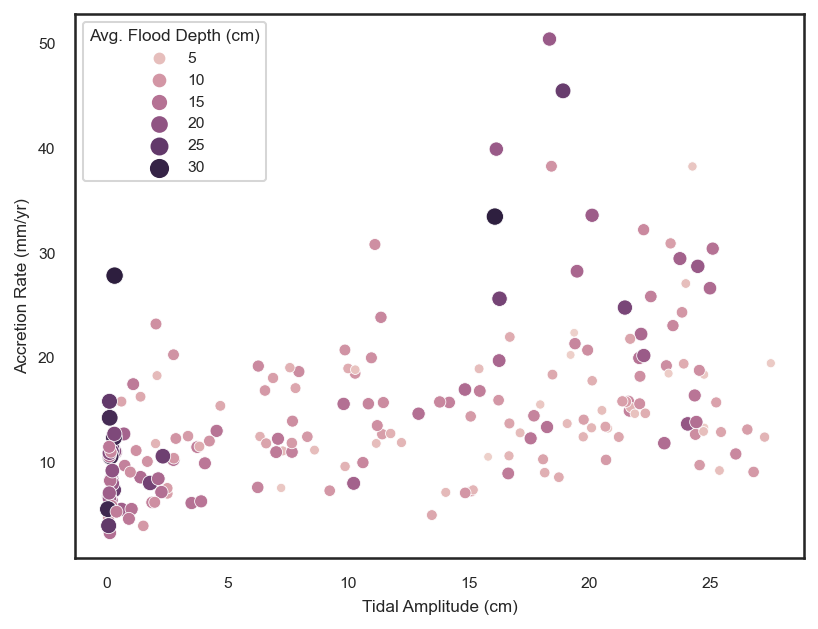

In [60]:
# scatter plots and histograms of tide amp and flood depths to explain the data before fitting
sns.scatterplot(data=df, y='Accretion Rate (mm/yr)', x='Tidal Amplitude (cm)', hue='Avg. Flood Depth (cm)',
               size='Avg. Flood Depth (cm)')
plt.show()

Tidal amplitude records the average daily difference between the highest and lowest flood recorded at CRMS station. While this may give us an idea of the depth of flooding tidal waters, it is more related to the position of the site within the tidal frame. The position of a station within a tidal frame is a summary variable that is related to many different aspects of the marsh ecosystem, including vegetation type, organic production, and modes of sedimentation. 

The scatter plot above shows us how tidal amplitude varies with accretion rate, where we can see a linear increase in accretion with respect to tidal amplitude. Notice that the points are colored by the average recorded flood depth of each site and that the highest average flood depth are actually higher in the tidal frame (lower tidal amplitude) with the exception of only a few. 

To further investigate this intruiging dynamic beween the flood depth, tidal amplitude, and accretion rate, let's investiagte another similar scatter plot

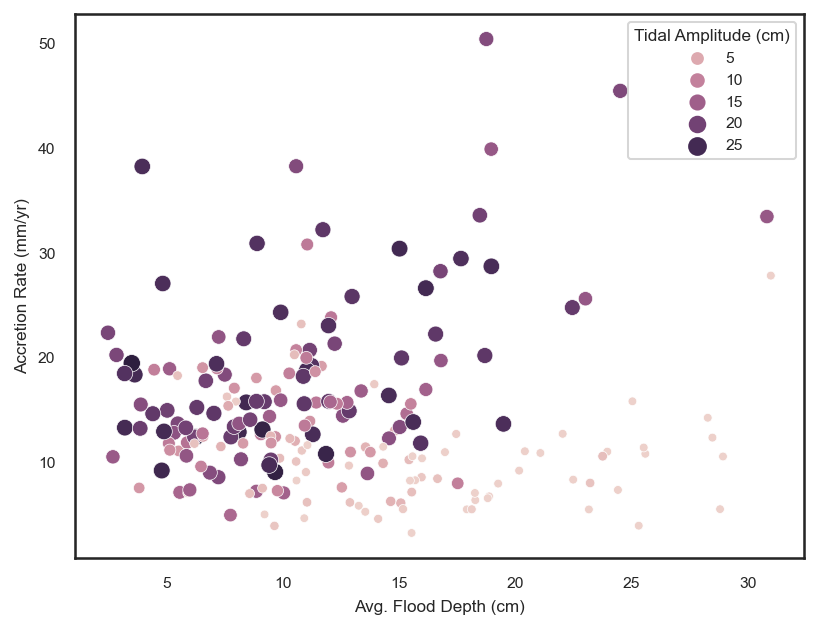

In [61]:
sns.scatterplot(data=df, y='Accretion Rate (mm/yr)', x='Avg. Flood Depth (cm)', hue='Tidal Amplitude (cm)',
               size='Tidal Amplitude (cm)')
plt.show()

By visualizing the relationship between average flood depth and accretion rate, colored by tidal amplitude, we can see that CRMS stations with high tidal amplitudes exhibit a stronger and more variable relationship between flood depth and accretion rate than stations with smaller tidal amplitudes. 

Now let us investigate how accretion, tidal amplitude, and the soil porewater salinity vary together to get an idea of where and how sediment is being deposited high in the tidal frame. We are investigating the soil porewater salinity term now because it will give us an idea about the hydrologic inputs into the marsh, less salinity indicates a fresh water hydrologic regime while high levels of salinity indicates a hydrologic regime closer to the ocean.

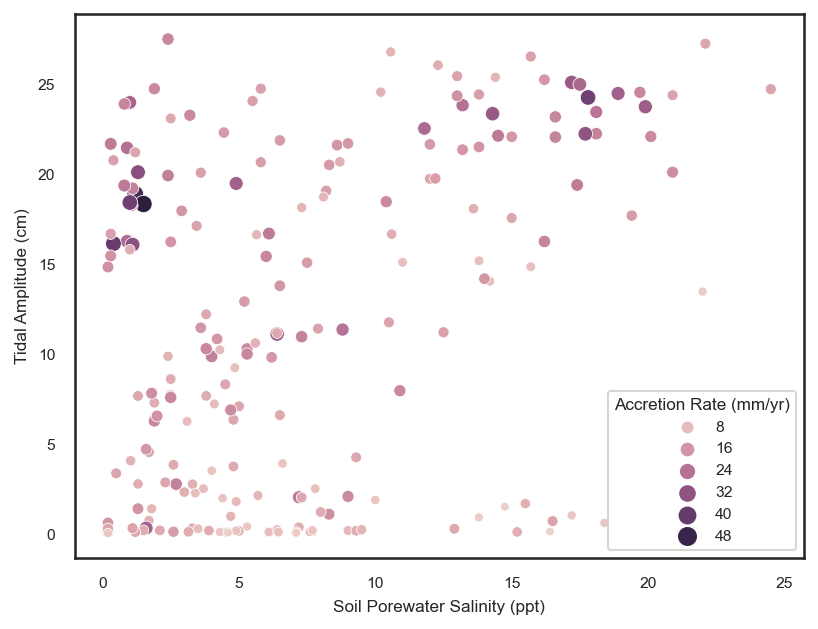

In [62]:
sns.scatterplot(data=df, y='Tidal Amplitude (cm)', x='Soil Porewater Salinity (ppt)', hue='Accretion Rate (mm/yr)',
               size='Accretion Rate (mm/yr)')
plt.show()

Here we can discern the idea that there are two local hotspots for sedimentation occurring high in the tidal frame, one in the upper left of the plot and in the upper right. What could be the determining factors of these sedimentation hotspots?

Let us take a look at which marsh communities these hotspots occur in.

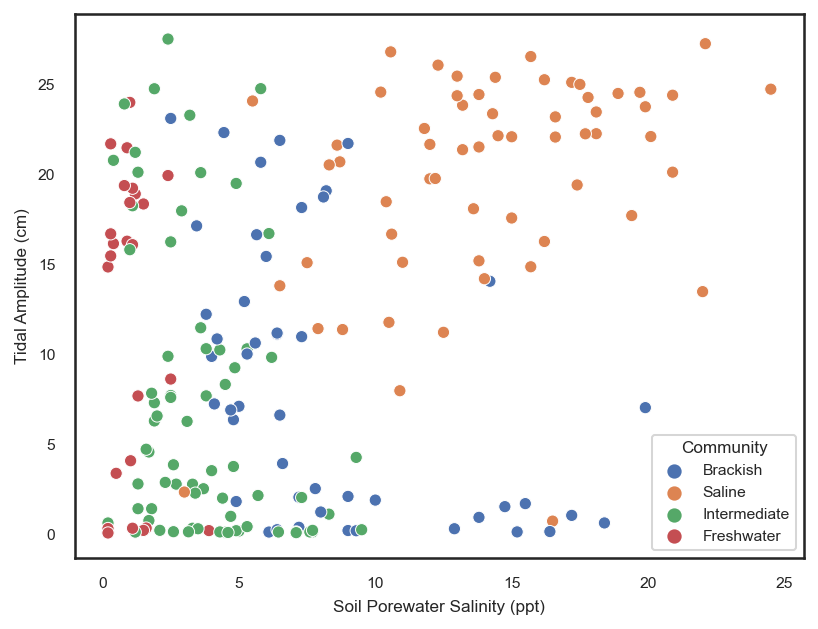

In [63]:
sns.scatterplot(data=df, y='Tidal Amplitude (cm)', x='Soil Porewater Salinity (ppt)', hue='Community')
plt.show()

Okay, so the sedimentation hotspots occur in the freshwater and intermediate marshes (upper left) and the saline marshes (upper right). One hypothesis for why these two distinct hotspot occur could be that there are two distinct modes of sediment transport here: from riverine flooding and from oceanic, storm and wave driven flooding. The riverine flooding is a likely culprit for introducing sediment into the freshwater marshes, while the ocean influenced flooding is the likely culprit in the marshes disconnected from rivers. Let us keep this in mind when we test our nonlinear Gaussian Process regression.


# The Bayesian Ridge Regression

In my implementation of Bayesian Ridge Regression model, I explicitly conduct repeated cross validation through a randomly splitting my dataset into K-folds and iterating this process 100 times through a loop. I do this in order to extract the learned parameters and predictions of each of the 500 models (5 fold splits repeated 100 times) and plot them in the subsequent graphs. 

However, I need to first make a function that unstandardizes the weight coefficents so they interpretable in the usual way: "a 1 unit increase in X resutls in a ... increase in y."

In [64]:
def unscaled_weights_from_Xstandardized(X, bayesianReg: linear_model):
    """
    This code only works for Bayesian Ridge Regression
    https://stackoverflow.com/questions/57513372/can-i-inverse-transform-the-intercept-and-coefficients-of-
    lasso-regression-after
    Better source:
    https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables
    """
    a = bayesianReg.coef_
    i = bayesianReg.intercept_
    # Me tryna do my own thing
    coefs_new = []
    for x in range(len(X.columns)):
        # print(X.columns.values[x])
        col = X.columns.values[x]
        coefs_new.append((a[x] / (np.asarray(X.std()[col]))))
    intercept = i - np.sum(np.multiply(np.asarray(coefs_new), np.asarray(X.mean())))  # hadamard product

    return coefs_new, intercept

Now, because linear regression models are prone to overfitting the data we need to select only the essential variables for predicting our outcome, vertical accretion rate. Overfitting the data occurs when our model ends up finding a function that aproximates our training data too much, so that when given new data it performs poorly.

The process of finding only the necessary variables for our model is called *feature selection* and there are two ways to proceed through it. Option one is to simply apply our domain knowledge on the subject we want to approximate, sedimentation on marsh environments. In this methodology, we will consult our previous knowledge on how sedimentation occurs in these environments and include every variable we deem necessary to model accretion rates. However, this approach is not always feasible for highly complex relationships or for situations where we do not have sufficient domain knowledge on our outcome variable. Option two applies an unbiased, reproducible methodology based on some metric. A popular choice for this approach is to use an algorithm called *backward feature selection.* In the algorithm, we fit a multivariate linear regression to our outcome variable using all of our data, then compute the p-value for each variable. We then iteratively drop the variable with the highest p-value until every variables has a p-value below a given threshold, generally 0.05. 

We are going to use the backward elimination approach to feature selection because marsh vertical accretion rates can depend on many different environemntal variables due these environemnts being at the confluence on land, rivers, and ocean. Therefore, we want to reduce the complexity of our linear regression for vertical accretion by only selecting statistically significant variables related to it. 

Below is our implementation of backward elimination.

In [65]:
def backward_elimination(data, target, num_feats=10, significance_threshold=0.05):
    """
    data: dataframe of predictors
    target: dataframe of target variable
    num_feats: maximum number of features to be included in the return list
    significance_threshold: threshold p-value that determines significance and elimination
    
    returns: list of significant variables
    
    Code is adapted from: 
    https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/#:~:text=1.-,Forward%20selection,with%20all%20other%20remaining%20features.
    """
    features = data.columns.tolist()
    target = list(target)
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_threshold) or (len(features) > num_feats):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

# Obtain a list of the significant variables
bestfeatures = backward_elimination(data=data, target=target, num_feats=10, significance_threshold=0.05)
print(bestfeatures)

['Soil Porewater Salinity (ppt)', 'NDVI', 'TSS (mg/l)', 'Avg. Time Flooded (%)', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)', '10th Percentile Flood Depth (cm)', 'Avg. Flood Depth (cm)']


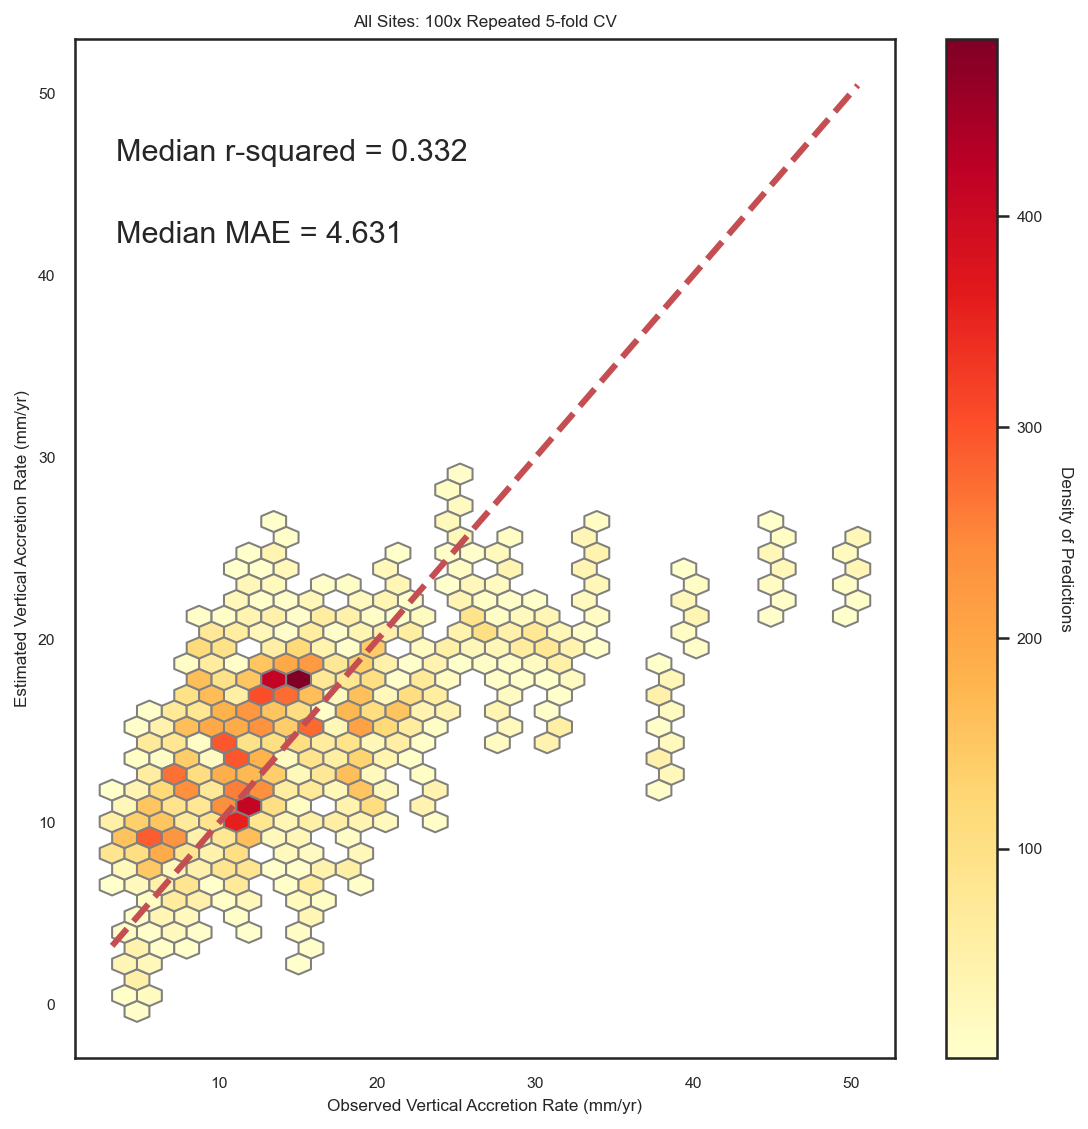

['Scaled Weights', 'Unscaled Weights', 'Scaled regularizors', 'Predictions']


In [66]:
# Plotting and parameter retrieval function for Ridge and BLR Ridge
def cv_results_and_plot(baymod, unscaled_predictor_matrix, predictor_matrix, target, color_scheme: dict):
    features = list(predictor_matrix.columns)
    # Error Containers
    predicted = []  # holds they predicted values of y
    y_ls = []  # holds the true values of y

    hold_weights = {}  # container that holds the learned weight vectors
    hold_unscaled_weights = {}  # container that holds the inverted learned weight vectors
    hold_regularizors = {}  # container that holds the learned regularization constant
    hold_predicted = {}

    # Performance Metric Containers: I allow use the median because I want to be more robust to outliers
    r2_total_medians = []  # holds the k-fold median r^2 value. Will be length of 100 due to 100 repeats
    mae_total_medians = [] # holds the k-fold median Mean Absolute Error (MAE) value. Will be length of 100 due to 100 repeats

    # parameter holders
    weight_vector_ls = []  # holds the learned parameters for each k-fold test
    regularizor_ls = []  # holds the learned L2 regularization term for each k-fold test
    unscaled_w_ls = [] # holds the inverted weights to their natural scales
    prediction_list = []

    for i in range(100):  # for 100 repeats
        try_cv = KFold(n_splits=5, shuffle=True)
        results_for_3fold = cross_validate(baymod, predictor_matrix, target.values.ravel(), cv=try_cv,
                                           scoring=('r2', 'neg_mean_absolute_error'),
                                           n_jobs=-1, return_estimator=True)
        # Scaled lists
        r2_ls = []
        mae_ls = []
        # Inversed lists
        r2_inv_ls = []
        mae_inv_ls = []
        # Certainty lists
        pred_list = []

        for train_index, test_index in try_cv.split(predictor_matrix):
            X_train, X_test = predictor_matrix.iloc[train_index], predictor_matrix.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]
            # Fit the model
            baymod.fit(X_train, y_train.values.ravel())
            # collect unscaled parameters
            unscaled_weights, intercept = unscaled_weights_from_Xstandardized(unscaled_predictor_matrix[features],
                                                                              baymod)
            unscaled_w_ls.append(unscaled_weights)

#             intercept_ls.append(intercept)
            # Collect scaled parameters
            weights = baymod.coef_
            weight_vector_ls.append(abs(weights))  # Take the absolute values of weights for relative feature importance
            regularizor = baymod.lambda_ / baymod.alpha_
            regularizor_ls.append(regularizor)
            design_m = np.asarray(X_train)
            eigs = np.linalg.eigh(baymod.lambda_ * (design_m.T @ design_m))

            # Make our predictions for y
            ypred = baymod.predict(X_test)
            pred_list += list(ypred)

            # Metrics for scaled y: particularly for MAE
            r2 = r2_score(y_test, ypred)
            r2_ls.append(r2)
            mae = mean_absolute_error(y_test, ypred)
            mae_ls.append(mae)
            # Metrics for inversed y: particularly for MAE
            r2_inv = r2_score(y_test, ypred)
            r2_inv_ls.append(r2_inv)
            mae_inv = mean_absolute_error(y_test, ypred)
            mae_inv_ls.append(mae_inv)

        # Average certainty in predictions
        prediction_list.append(pred_list)

        # Average predictions over the Kfold first: scaled
        r2_median = np.median(r2_ls)
        r2_total_medians.append(r2_median)
        mae_median = np.median(mae_ls)
        mae_total_medians.append(mae_median)

        predicted = predicted + list(cross_val_predict(baymod, predictor_matrix, target.values.ravel(), cv=try_cv))
#         residuals = residuals + list(target.values.ravel() - cross_val_predict(baymod, predictor_matrix, 
#                                                                           target.values.ravel(), cv=try_cv))
        y_ls += list(target.values.ravel())

    # Add each of the model parameters to a dictionary
    weight_df = pd.DataFrame(weight_vector_ls, columns=features)
    unscaled_weight_df = pd.DataFrame(unscaled_w_ls, columns=features)
    
    # Now calculate the mean of th kfold means for each repeat: scaled accretion
    r2_final_median = np.median(r2_total_medians)
    mae_final_median = np.median(mae_total_medians)
    
    # Below code is for the figure
    fig, ax = plt.subplots(figsize=(9, 9))
    hb = ax.hexbin(x=y_ls,
                   y=predicted,
                   gridsize=30, edgecolors='grey',
                   cmap=color_scheme['cmap'], mincnt=1)
    ax.set_facecolor('white')
    ax.set_xlabel("Observed Vertical Accretion Rate (mm/yr)")
    ax.set_ylabel("Estimated Vertical Accretion Rate (mm/yr)")
    ax.set_title("All Sites: 100x Repeated 5-fold CV")
    cb = fig.colorbar(hb, ax=ax)
    cb.ax.get_yaxis().labelpad = 15
    cb.set_label('Density of Predictions', rotation=270)
    ax.plot([target.min(), target.max()], [target.min(), target.max()],
        color_scheme['line'], lw=3)

    ax.annotate("Median r-squared = {:.3f}".format(r2_final_median), xy=(20, 450), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    ax.annotate("Median MAE = {:.3f}".format(mae_final_median), xy=(20, 410), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    plt.show()
    
    return {
        "Scaled Weights": weight_df, 
        "Unscaled Weights": unscaled_weight_df, 
#         "Unscaled Intercepts": intercept_ls, 
        "Scaled regularizors": regularizor_ls, 
#         "# Well Determined Weights": weight_certainty_ls, 
#         "Standard Deviations of Predictions": prediction_certainty_ls, 
        "Predictions": prediction_list, 
#         "Residuals": residuals, 
#         "Predicted for Residuals": predicted 
    }


results_dict = cv_results_and_plot(br, phi, data[bestfeatures], target, {'cmap': 'YlOrRd', 'line': 'r--'})
# lets look at the keys of the returned results dictionary for future reference
print(list(results_dict.keys()))

Using the found significant variables, our implemented Bayesian Linear Regression was able to capture ~0.33% of the variablity associated with accretion. The scatter plot above is a one-to-one plot of the estimated versus observed accretion values. We can see how most of our error is assocaited with predicting the vertical accretion rates greater than 25 mm/yr. This can be due to a plethora of reasons, however, the most parsimonous seems to be because more stochastic processes which we were unable to capture with our chosen environmental variables dictate the deposition of sediment in these areas.

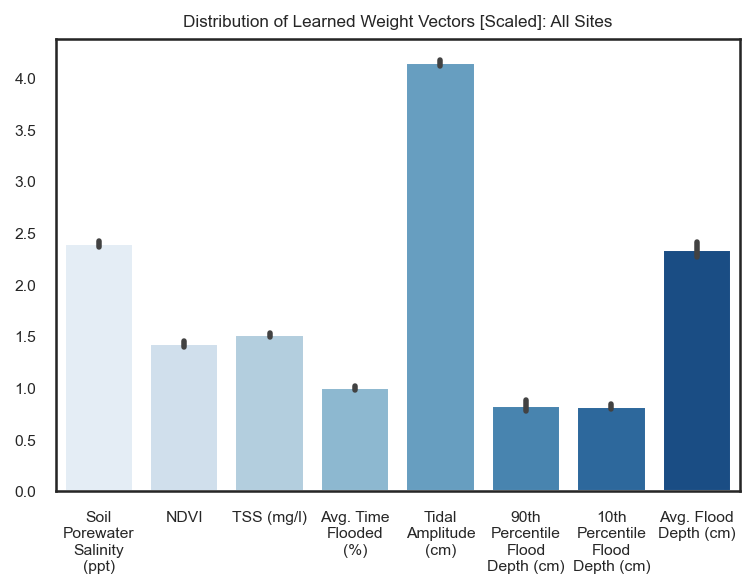

Soil Porewater Salinity (ppt)       2.393223
NDVI                                1.427119
TSS (mg/l)                          1.514635
Avg. Time Flooded (%)               1.003500
Tidal Amplitude (cm)                4.146350
90th Percentile Flood Depth (cm)    0.828273
10th Percentile Flood Depth (cm)    0.820359
Avg. Flood Depth (cm)               2.340389
dtype: float64

In [67]:
def wrap_labels(ax, width, break_long_words=False):
    """ This function is only for the visualization of plots
    
    ax: plot axis object 
    width: width of textwrap
    break_long_words: boolean as to break long words in wrapping or not
    
    directly from: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    """
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    
# Lets plot the feature importances from the collected scaled weights
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Scaled]: All Sites')
sns.barplot(data=results_dict['Scaled Weights'], palette="Blues")
wrap_labels(ax, 10)
plt.show()

results_dict['Scaled Weights'].mean()

The bar chart above indicates the relative feature importances of the identified variables. Of the identified salient variables from the dataset related to accretion, we see that tidal amplitude is the most important variable contributing to accretion in our linear model, while suspended sediment concetration is the least important variable contributing to accretion in the model. However, be sure to note that suspended sediment is still a significant variable defined by the backward elimination algorithm.

Something to consider here is the multicollinearity between the variables that is inherent to these environments. We must acknowledge that this potential bias may affect any future interpretations of the model. Additionally, the feature importances of each variable will vary depending on which type of model they are fit to. 

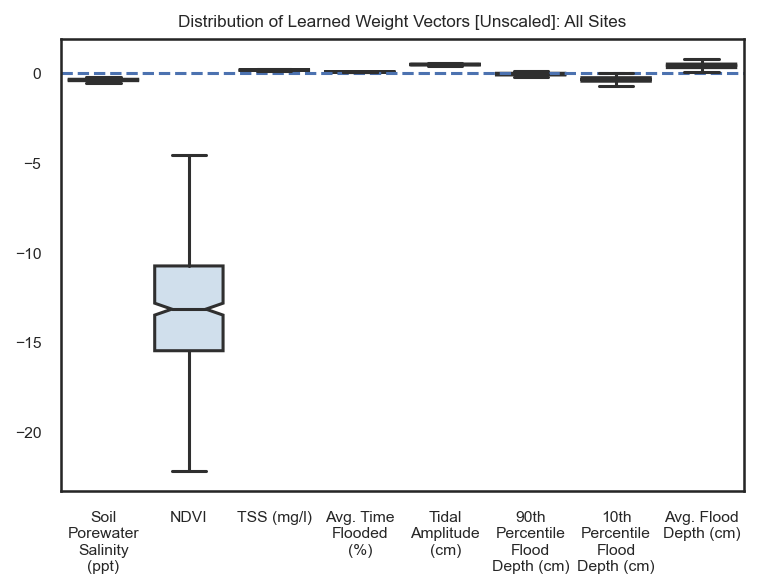

Soil Porewater Salinity (ppt)       -0.404271
NDVI                               -13.160938
TSS (mg/l)                           0.139653
Avg. Time Flooded (%)                0.040442
Tidal Amplitude (cm)                 0.451501
90th Percentile Flood Depth (cm)    -0.084456
10th Percentile Flood Depth (cm)    -0.380075
Avg. Flood Depth (cm)                0.383722
dtype: float64

In [68]:
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Unscaled]: All Sites')
ax.axhline(0, ls='--')
boxplot = sns.boxplot(data=results_dict['Unscaled Weights'], notch=True, showfliers=False, palette="Blues")
wrap_labels(ax, 10)
plt.show()

results_dict["Unscaled Weights"].mean()

The above plot is now the unscaled weight coefficents. They are representaed through a boxplot because, since we run a 5-fold 100x repeated cross validation scheme, we train 500 models with slightly different learned weights because of slightly different splits of the data. Therefore, it is important to show the full range of the learned weights. We can intepret these as one would usually for any ordinary least squares regression such as "a one centimeter increase in tidal amplitude results in a ~0.45 mm/yr increase in the vertical accretion rate at a CRMS station."

These weight coeffiecents give us both the magnitude and direction of change. An increase in soil porewater salinity, NDVI, 90th percentile flood depth, and 10th percentile flood depth all negatively influence our models estimated accretion rate. While TSS, tidal amplitude, average percent time flooded, and flood depth all positively influence estimated deposition rates.

## SHAP Analysis

SHapley Additive exPlanations, SHAP, is a python package to explain how your model makes predictions after training. This is called *post hoc explainability* by Roscher et al 2020. The package is easy to install and use on a variety of different models.

The idea of using SHAP values for machine learning explainability comes from cooperative game theory. Where each sample of data acts like a player in a game, that can be marked as "present" in the game or "absent" in the game. The computation of SHAP values can be very difficult and complicated, but they have a simple interpretation. The SHAP value is essentially able to quantify each sample's contribution to the expected target variable. Allowing us to see how predictions vary across samples as well as across features.

The analysis that I present will show how to use some basic functions in the package to gather feature importance and feature dependence plots. However, there is a variety of other types of analysis one could do, depending on the model, that are described in the docs: https://shap.readthedocs.io/en/latest/

## SHAP on the Bayesian Ridge Regression

To get a basic understanding of what the Shapely values are and how to use them, I will give some explanations using the Bayesian Ridge, linear regression model. I do this because we already know how a linear regression model will approximate the output variable and can better understand how any models predictions are related to the Shapely values.

Acquired from game theory, Shapely values seek to quantify the relative involvement of players in a game. In our case, the “players” are the features in the GPR model, and the “game” is the task of predicting vertical accretion rates. 

To evaluate the contribution of each feature, the explainability model can be regarded simply as 
$$\hat{f}(x)= \bar{f}(x) + \sum_{j=1}^{M} \phi_j$$

Where $\hat{f}(x)$ is the predicted target, $\bar{f}(x)$ is the mean of all the predicted values, and $\phi_j$ is the contribution of the $j^{th}$ feature of the $M$ total features.

To compute individual Shapely values, we want to know the relative influence of single sample of a single feature within a group of many features on the target variable. This is done by including and excluding a feature, for instance the $j^{th}$ feature, from every possible set of the features that comprise the GPR model we defined. We then randomly sampling a value from each feature of the subset, compute the estimated outcome including the random sample of the feature interest, compute the estimated outcome excluding the feature of interest, then subtract the two estimations from each other. The difference is the Shapely value, making the Shapely value the average contribution of a feature across all possible subsets of features. This can be thought of mathematically below (Molnar 2019, Štrumbelj and Kononenko 2014):
$$\phi_j=\frac{1}{M} \sum_{m=1}^{M} \hat{f}(x)_{-j}^m - \hat{f}(x)_{+j}^m$$

Where $\hat{f}(x)_{-j}^m$ is excluding the feature of interest, the $j^{th}$ feature, for the $m^th$ subset and $\hat{f}(x)_{+j}^m$ is including the feature of interest for the m^th subset. In our case the Shapely values will be in terms of influence on vertical accretion rate mm/yr.

We can see that the calcualtion of shapely values can become prohibitively computationally expensive. Therefore, an appropriate approximation method, such as a Monte-Carlo sampling method, is often employed to optimize the computation (Štrumbelj and Kononenko 2014).

The below bar plot will show the feature importances of each feature computed from shapely values. the importance scores are determined by averaging the absolute shapely values per feature across the data such that (Molnar 2019):

$$ Importance_j = \frac{1}{N} \sum_{n = 1}^{N} |\phi_j^n|$$

Where $Importance_i$ indicates the importance of the $j^{th}$ feature, $\phi_j^n$ indicates the shapely value of the $i^{th}$ sample of the $j^{th}$ feature, and $N$ indicates the total number of samples.


<class 'pandas.core.frame.DataFrame'>


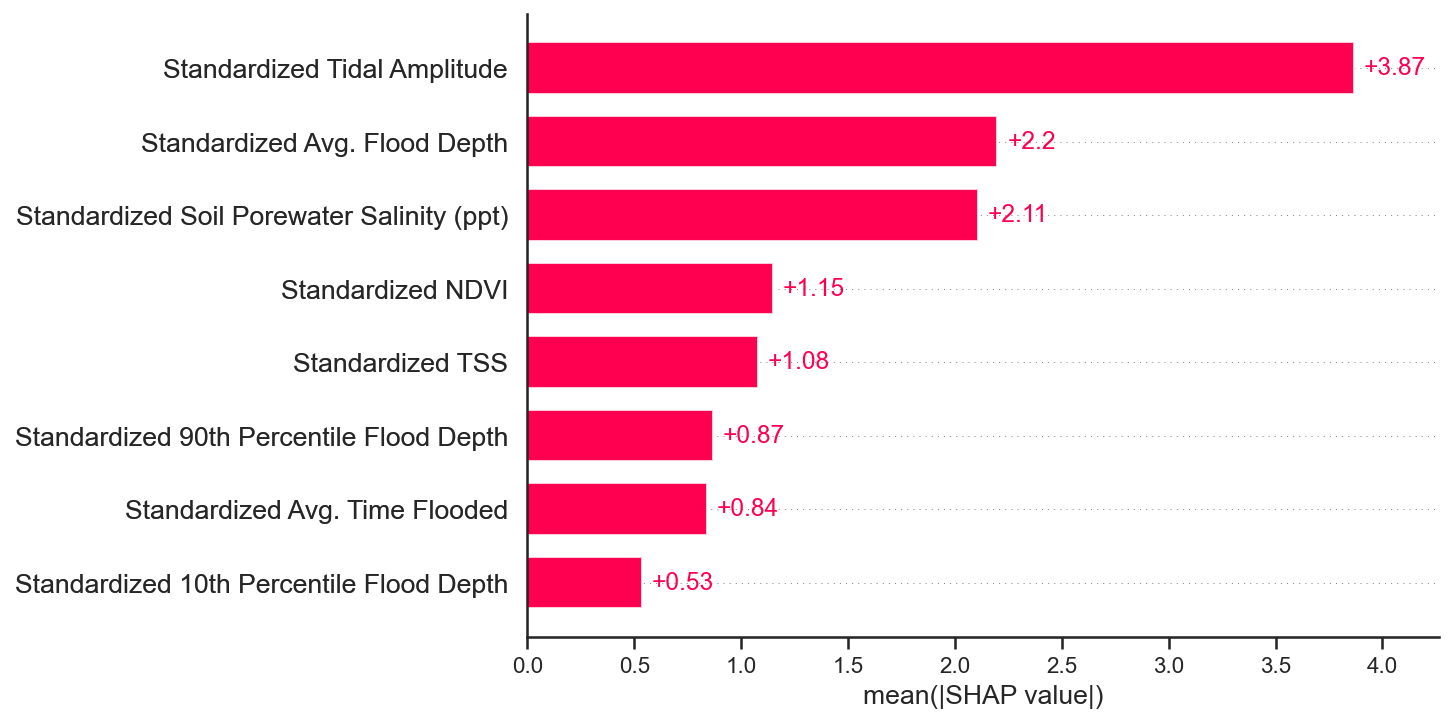

In [80]:
# Make a dataframe specifically for shap
shap_df = data[bestfeatures]
# include "standardized" in the feature names to make it clear that these features are standardized
shap_df = shap_df.rename(columns={'Tidal Amplitude (cm)': 'Standardized Tidal Amplitude',
                                 'Avg. Flood Depth (cm)':'Standardized Avg. Flood Depth',
                                 '90th Percentile Flood Depth (cm)': 'Standardized 90th Percentile Flood Depth',
                                 'Soil Porewater Salinity (ppt)': 'Standardized Soil Porewater Salinity (ppt)', 
                                 'NDVI': 'Standardized NDVI', 
                                 'TSS (mg/l)': 'Standardized TSS', 
                                 'Avg. Time Flooded (%)': 'Standardized Avg. Time Flooded',
                                 '10th Percentile Flood Depth (cm)': 'Standardized 10th Percentile Flood Depth'}
                        )

# fit the model first
br.fit(shap_df, target)
# Shap Analysis
X500 = shap.utils.sample(shap_df, 500) # randomly sample 100 instances for use as the background distribution
print(type(X500))
explainer_ebm = shap.Explainer(br.predict, X500)  # explain a random sample of the data
# explainer = shap.Explainer(gp)
shap_values_ebm = explainer_ebm(X500)

shap.plots.bar(shap_values_ebm)

We see that the feature importances computed by the SHAP values are almost the same as our computed feature importances values using only the mean of the learned weight vectors, given scaled predictor variables. 

We can visualize a more informative representation of the feature importances using the summary plot method from SHAP. This plot gives us the order of feature importances, the distribution of shapely values, and an idea of the direction of influence each feature has on the outcome. Similar to the above bar plot, the feature importances are in descending order. From where the points are located horizontally, to the right or left of the SHAP value equals 0 (x-axis), we can determine whether that points holds positive or negative influence on the outcome. If the distribution of the shapely values widens, this means more shapely values lie in that range. Depending on whether the widening lies to the left or right of the $0$ on the x-axis, we can determine whether the majority of samples hold a positive or negative influence on accretion. The colorbar on the right of plot indicates the specific feature's importance value for that given sample. 

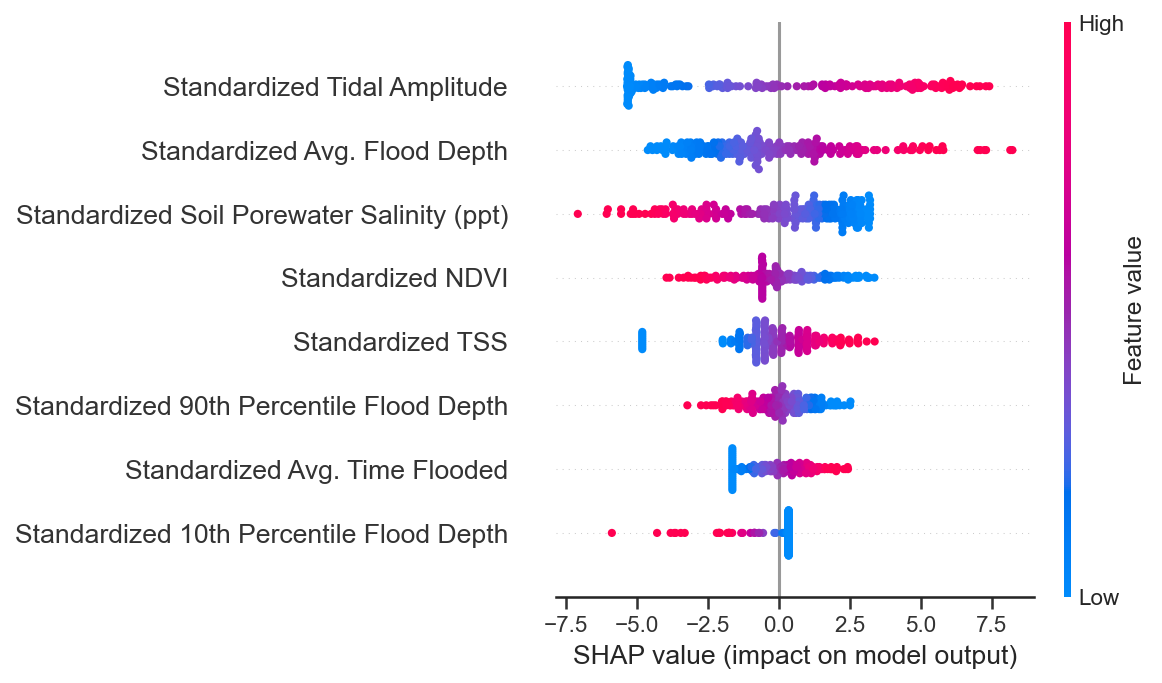

In [83]:
shap.summary_plot(shap_values_ebm, features=shap_df, feature_names=shap_df.columns.values)

Examining the three most important features in the summary plot, we see that tidal amplitude as a net positive affect on the outcome as indicated by the red colorbar, while a substantial amount of the samples are contributing negatively to accretion rate. Average flood depth also has a net positive effect on vertical accretion rate, while, again, much of the samples contribute negatively to vertical accretion rate. Opposite to tidal amplitude and average flood depth, soil porewater salinity contributes negatively to vertical accretion rate, while much of the samples actually contribute positively!


## Partial Dependence Plots and SHAP Dependence Plots

Partial dependence plots are show the marginal effect of a feature and the resultant outcome variable given our model (Molnar 2019), helping us get an idea of the type of relatinship the two variables have together. Given that we are looking at the partial dependence plots within a linear regression, we will expect to see only linear relationships in these plots between outcome and feature. 

The SHAP dependence plots are similar to the partial dependence plots, however just slightly different. Rather than the expected outcome on the y-axis, the shapely value is represented. While the partial dependence plot will roughly approximate the trends of the SHAP dependence plots. 

Let us examine the partial dependence plots for the 3 main contributors to accretion. 

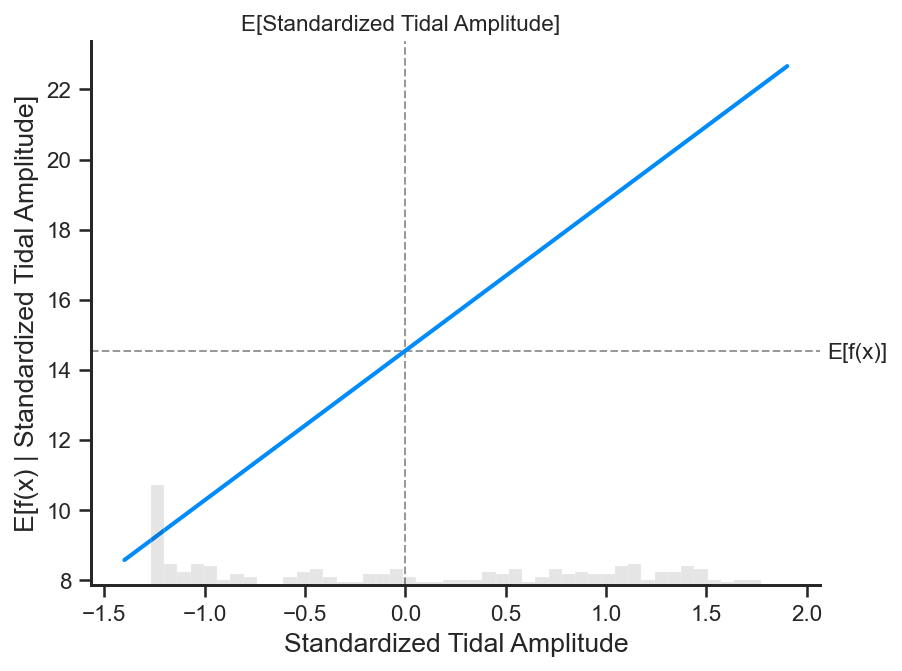

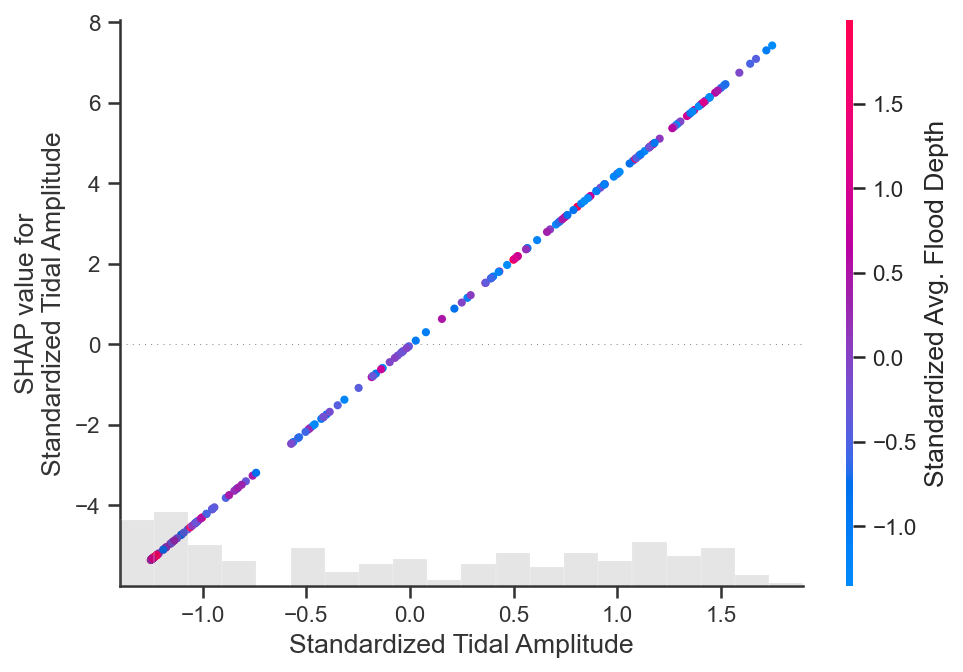

In [85]:
shap.partial_dependence_plot(
    'Standardized Tidal Amplitude', br.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "Standardized Tidal Amplitude"],
                   color=shap_values_ebm[:,"Standardized Avg. Flood Depth"])

Tidal amplitude has a clear positive relationship with the expected vertical accretion outcome as depicted by the partial dependence plot. The SHAP dependence plots displays a similar story, while the samples are colored by the normalized average flood depth value. However, there is no clear relationship between certain average flood depth values and increasing or decreasing expected outcomes.

Next we are going to investigate the average flood depth, the second most important variable in our BLR model. But, we must also take a lot at the 90th percentile of the flood depth along with the average flood depth because the two are inherently intertwined. As flood depth increases, we expect the 90th percentile of the flood depth to increase as well. The below scatter plot reinforces this notion.

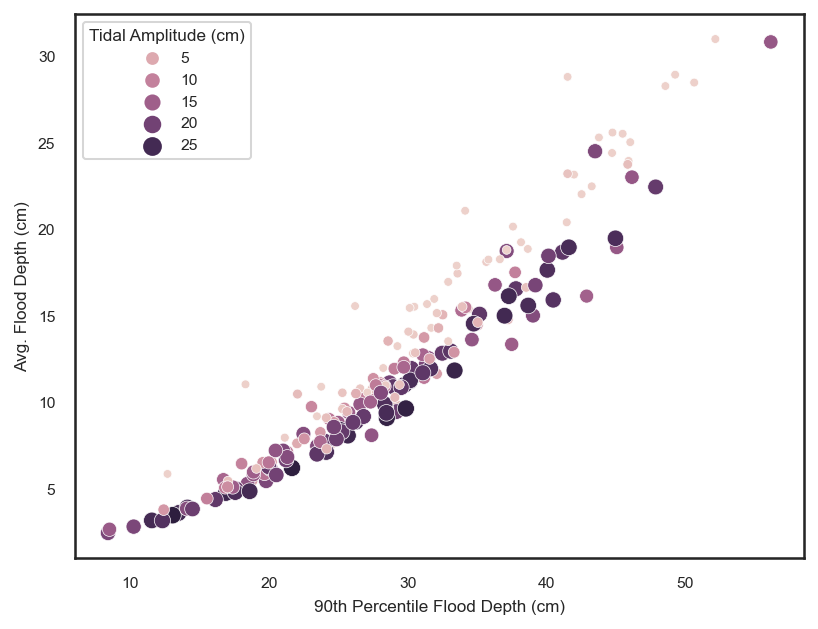

In [86]:
sns.scatterplot(data=df, x='90th Percentile Flood Depth (cm)', y='Avg. Flood Depth (cm)', hue='Tidal Amplitude (cm)',
               size='Tidal Amplitude (cm)')
plt.show()

Since we know that there is clear interaction between these two variables, we need to understand their interactions. The same way we implemented in the SHAP dependence plot for the tidal amplitude and average flood depth, we can plot average flood depth and the 90th percentile flood depth and vice versa.

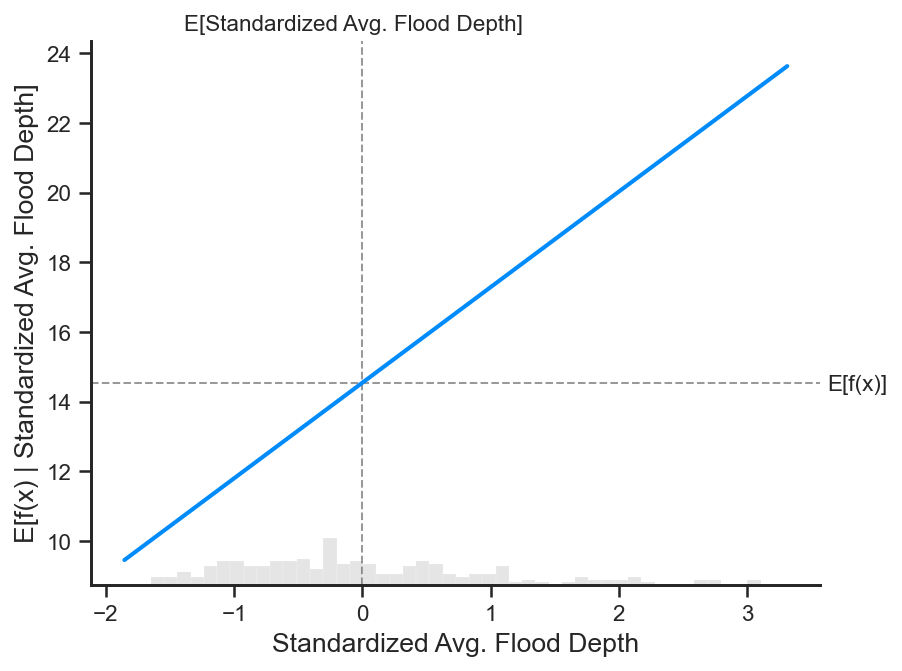

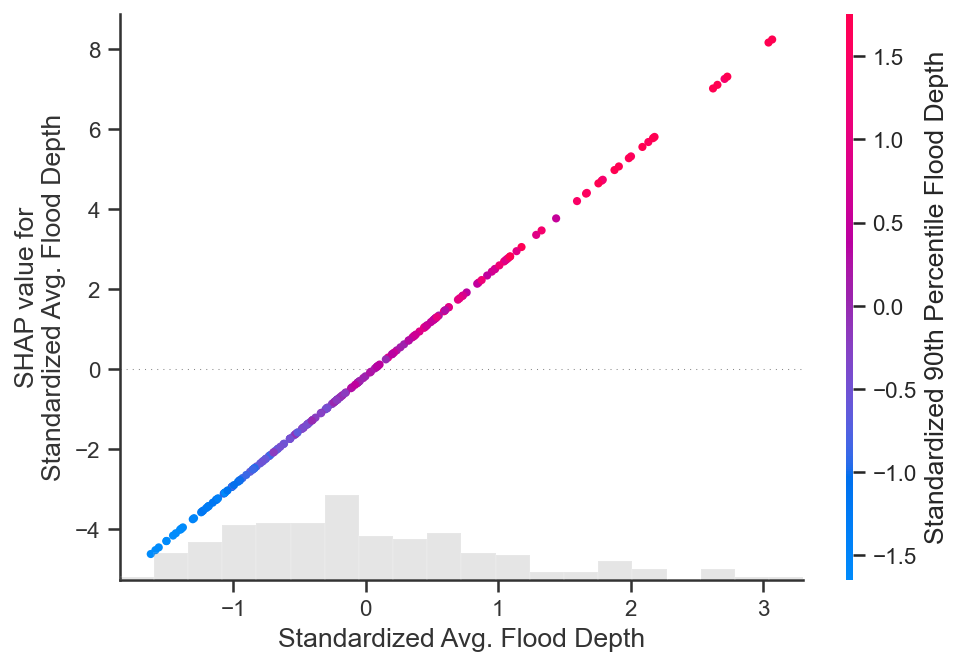

In [87]:
# Let us look at the partial dependence plot for Avgerage flood depth
shap.partial_dependence_plot(
    "Standardized Avg. Flood Depth", br.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the SHAP dependence plot for average flood depth
shap.plots.scatter(shap_values_ebm[:, "Standardized Avg. Flood Depth"],
                   color=shap_values_ebm[:,"Standardized 90th Percentile Flood Depth"])

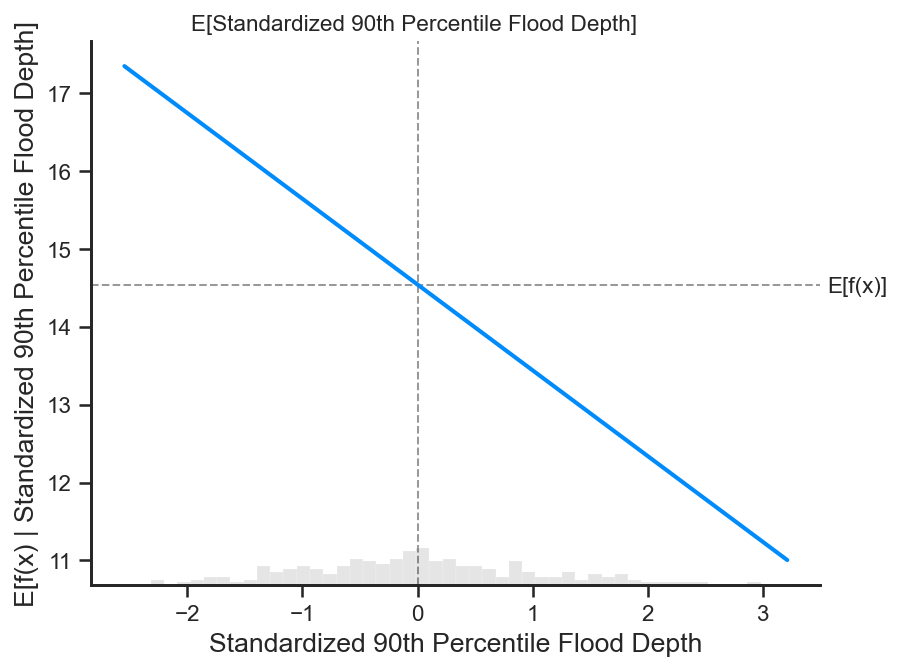

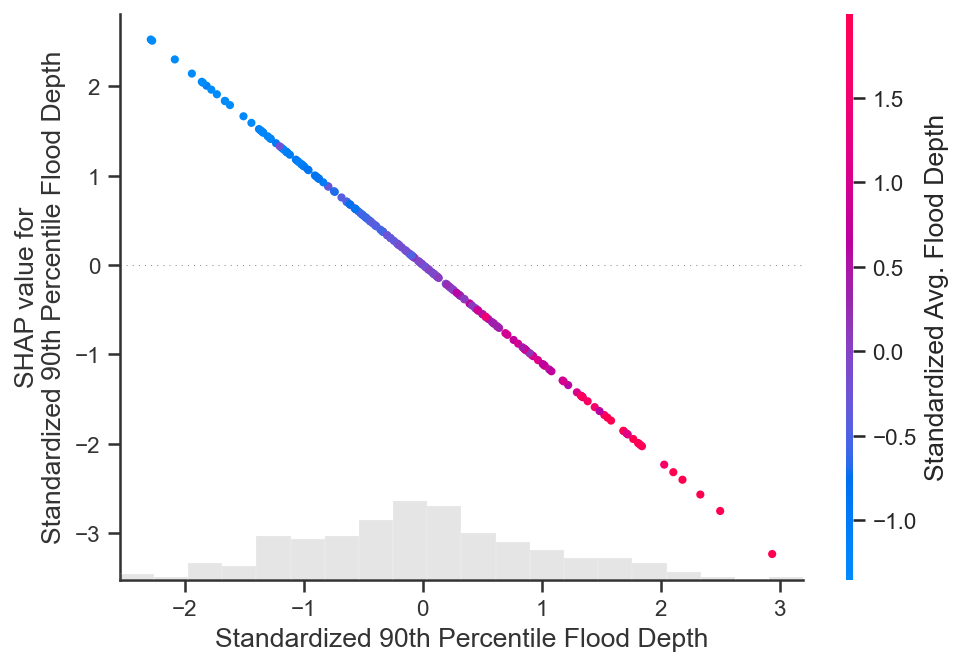

In [88]:
shap.partial_dependence_plot(
    "Standardized 90th Percentile Flood Depth", br.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "Standardized 90th Percentile Flood Depth"],
                   color=shap_values_ebm[:,"Standardized Avg. Flood Depth"])

As expected, the 90th percentile of flood depth naturally increases with the average flood depth. From both the weight coefficents and the partial dependence slopes, we notice that they have opposite effects on the vertical accretion. While the average flood depth increases expected vertical accretion within the BLR, the 90th percentile flood depth decreases the expected vertical accretion. One can interpret this as the 90th percentile flood depth, or large scale floods, acting as *checks* on vertical accretion. A working hypothesis for this relationship could be that a consistent flooding regime with deeper floods seems to be associated with increased sedimentation due to the soil and vegetation being adapted to withstanding the shear forces assocaited with the average floods. However, bringing in an infrequent large scale flood likely exceeds the critical shear stress of the soil and vegetation which leads to the erosion of material. 

# Gaussian Process Regression

In [89]:
# Load packages relevant for the gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel, Matern, Sum

# GP model 
gp = GaussianProcessRegressor(kernel=(DotProduct()**2) + WhiteKernel(),
                              n_restarts_optimizer=10, alpha=1, normalize_y=False, random_state=123)

rcv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=123)
scores = cross_validate(gp, shap_df, target, cv=rcv, 
                        scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("Median GP R^2 score", np.median(scores['test_r2']))
print("Median GP MAE score", abs(np.median(scores['test_neg_mean_absolute_error'])))

Median GP R^2 score 0.42930750447576793
Median GP MAE score 4.2443868334086385


You may have noticed that we simply assigned a kernel for our problem. Recall that the kernel assigns similarities between samples for each feature interaction then acts as the covariance matrix for the GPR. We do this because of our underlying assumption that similar samples should have similar effects on the output variable. 

Our choice of kernel is the squared dot product kernel with the addition of some gaussian distributed noise. We can visualize it with the function plotted below. 

Assuming that the x-axis is one feature, the y-axis is another feature, and the z-axis (vertical) is their similarity. I constrain the plot to be between -1 and 1 because we can consider this values as standard deviations from the mean, with $0$ as the mean. Our data is scaled the below function is great for visualize how the kernel captures the similarity of samples between two features.

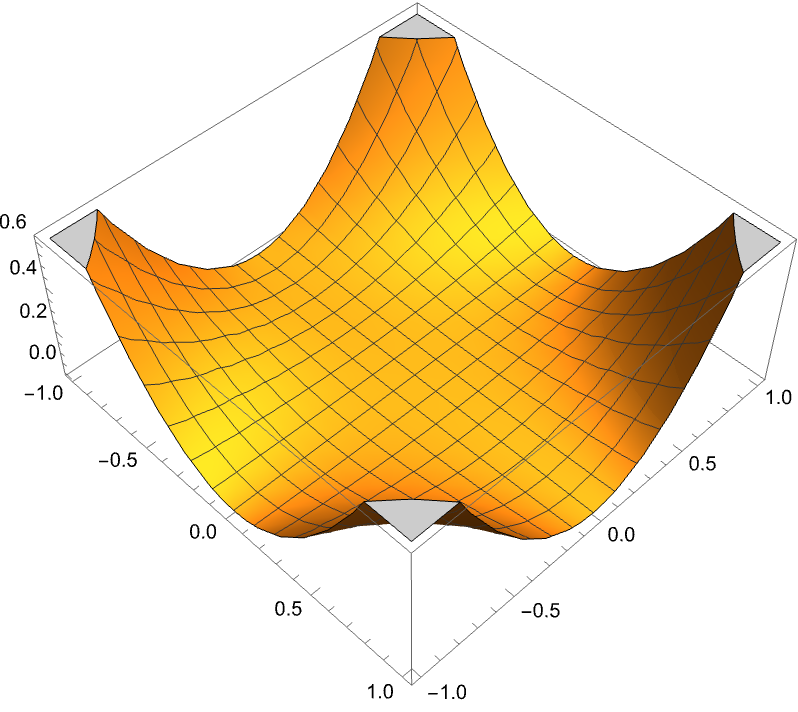

We see that the areas representing the most similar effects on the output will occur when both samples lie at the end member s of their respective distributions. 


## SHAP Analysis for Gaussian Process Regression

To visualize the nonlinear dynamics captured by the Gaussian Process Regression, we will implement the same SHAP analysis as we did for the Bayeisan Linear Regression. Notice that the form kernel function will largely dictate the type of functions that will be represented between the features and vertical accretion rate. 

<class 'pandas.core.frame.DataFrame'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


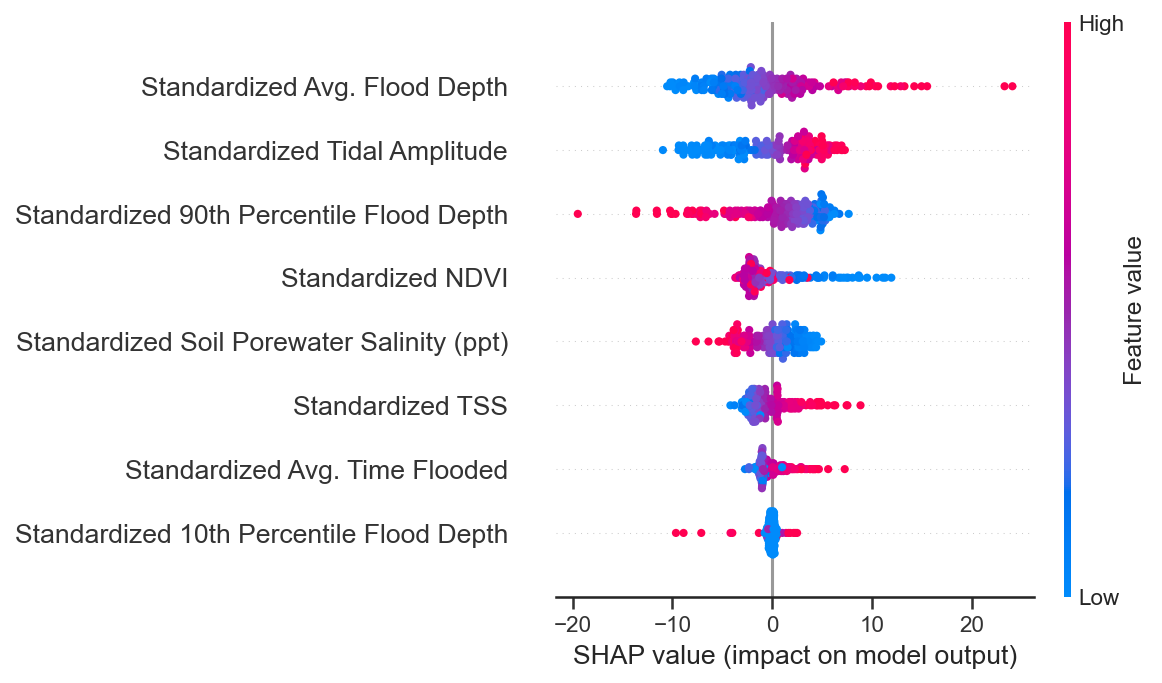

In [90]:
# fit the model first
gp.fit(shap_df, target)
# Shap Analysis
X500 = shap.utils.sample(shap_df, 500) # randomly sample 100 instances for use as the background distribution
print(type(X500))
explainer_ebm = shap.Explainer(gp.predict, X500)  # explain a random sample of the data
# explainer = shap.Explainer(gp)
shap_values_ebm = explainer_ebm(shap_df)

shap.summary_plot(shap_values_ebm, features=shap_df, feature_names=shap_df.columns.values)

While average flood depth and tidal amplitude are still identified as the most important variables, the importance of the other variables changes slightly in the GPR model. Let us look at the partial and SHAP dependence plots to get a further idea about the difference between our GPR and BLR models.

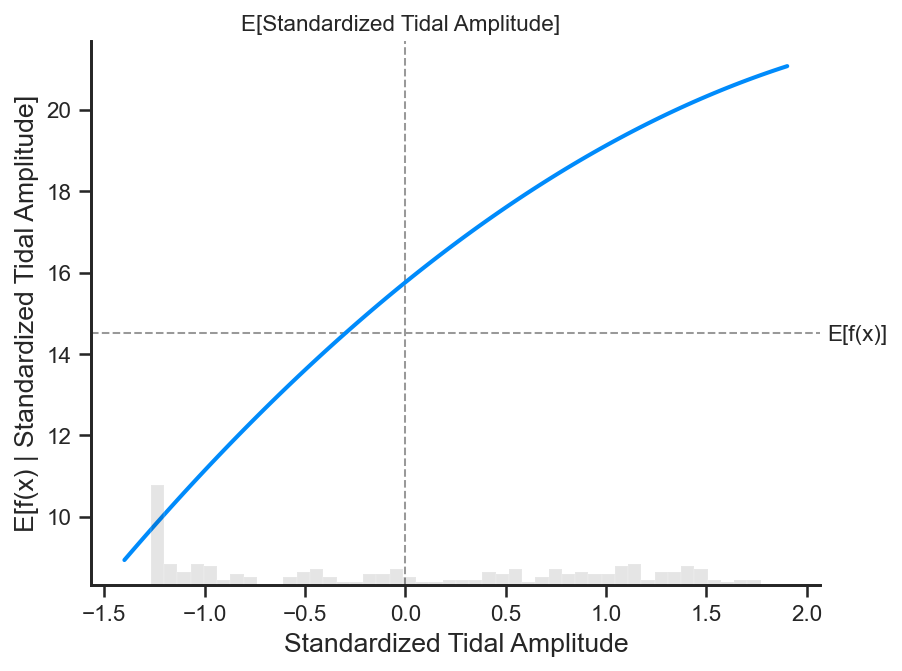

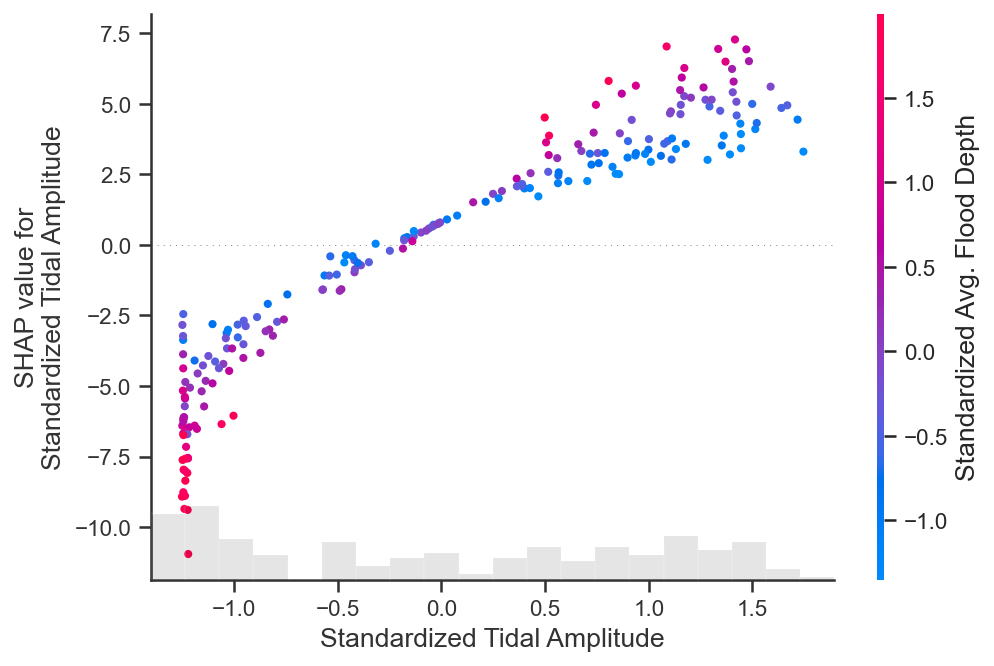

In [91]:
# Plot the partial dependence of the tidal amplitude within the GPR
shap.partial_dependence_plot(
    'Standardized Tidal Amplitude', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot of tidal amplitude within the GPR, colored by average flood depth
shap.plots.scatter(shap_values_ebm[:, "Standardized Tidal Amplitude"],
                   color=shap_values_ebm[:,"Standardized Avg. Flood Depth"])

The zero in the x-axis indicates that mean of the tidal amplitude data distribution, while each unit is in standard deviations. We notice that across the mean of the tidal amplitude data, standard deviation equal 0.0, flood depths have a opposite association with tidal amplitude and accretion rate. Where tidal amplitudes are below the mean, flood depth decreases with increasing tidal amplitude, while the expected accretion rate increases. Where tidal amplitudes are above the mean, flood depths increase with increasing tidal amplitude, while the expected accretion rate also increases.

The relationship here really highlights the dominance of the tidal amplitude, or the relative position of a CRMS station in the tidal frame, as a predictive variable for accretion rate. Additionally, with tidal amplitude increasing with flood depth above the mean tidal amplitude, we may expect this to be due to a greater influence of oceanic flood waters on flooding. 

To test qualitatively test this, we can look at the relationship between tidal amplitude, flood depth, and soil porewater salinity, assuming that an increase in the soil porewater salinity is associated with a more saline flooding regime.

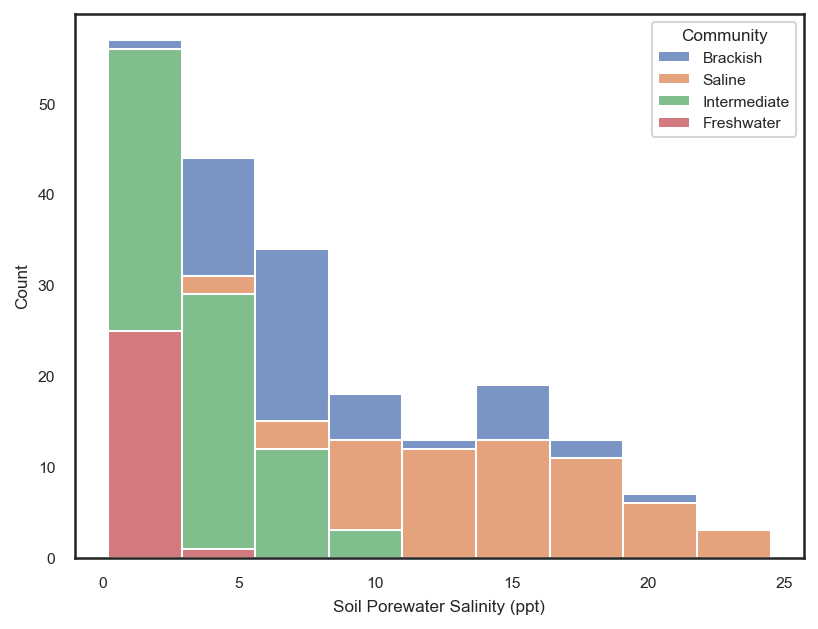

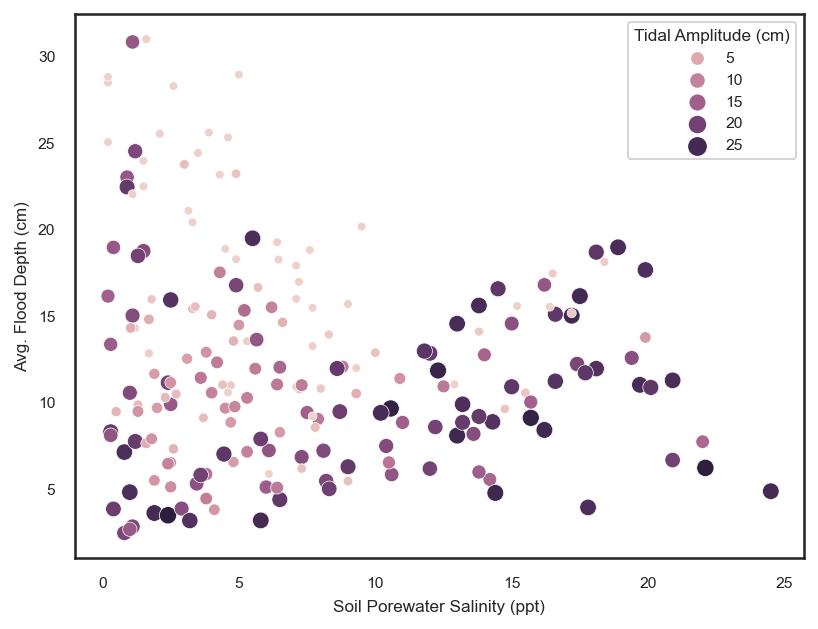

In [92]:
# Histogram to see splits in salinity distributions across marsh types
sns.histplot(data=df, x='Soil Porewater Salinity (ppt)', hue='Community', multiple='stack')
plt.show()
# scatter
sns.scatterplot(data=df, x='Soil Porewater Salinity (ppt)', y='Avg. Flood Depth (cm)', hue='Tidal Amplitude (cm)',
               size='Tidal Amplitude (cm)')
plt.show()

The stacked histogram shows us that the distribution of salinity values in the saline marsh sites deviate from the fresher water sites around a value of ~10 ppt. By examining the subsequent scatter plot, we see that above salinity values of ~10 ppt, in the saline marshes, there is a positive trend between salinity and flood depth. While, for salinity values less than ~10 ppt, there is no relationship to a weak logarithmic relationship between flood depth and salinity. This could be potentially highlighting the difference in flooding regimes between the saline sites and the fresher water sites. Where in the saline marshes, floods predominately originate from the ocean, bringing with them more saline water to the marshes. While in the fresher waters, flood waters are more variable to dominantly freshwater floods originating from the nearby rivers and bayous or terrestrial hydrologic regime.

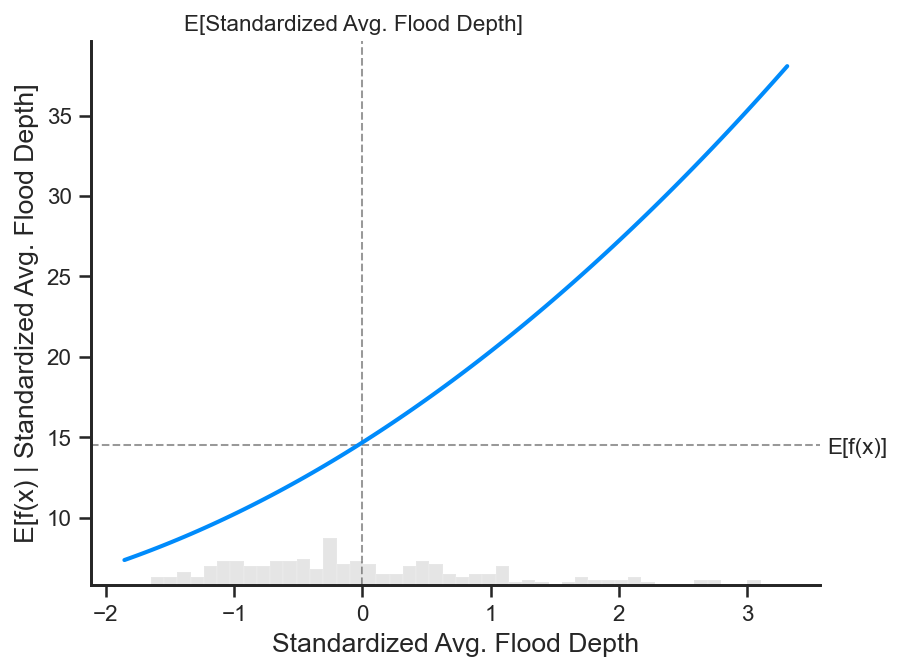

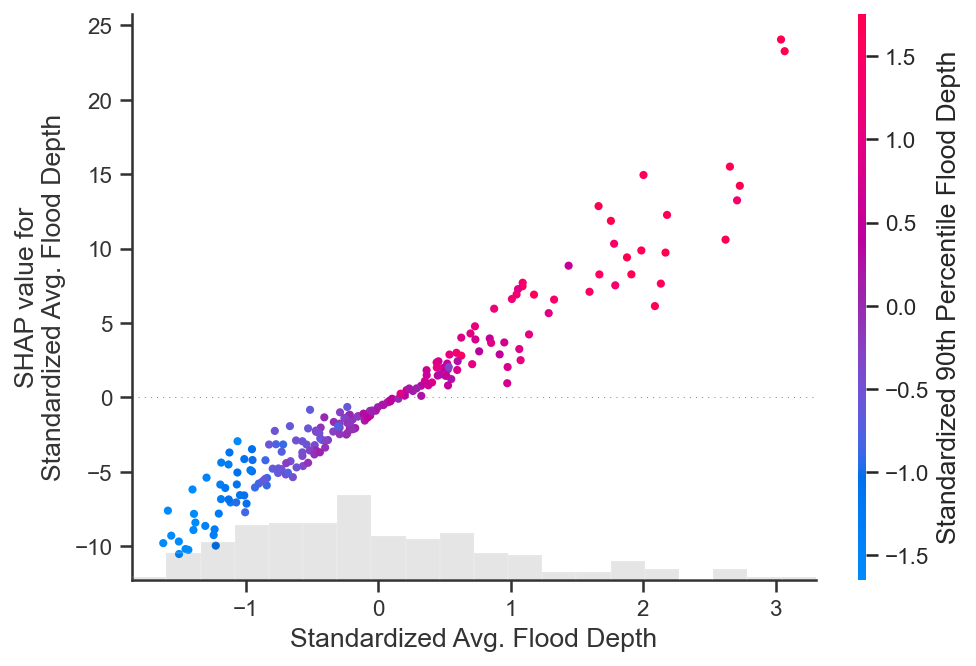

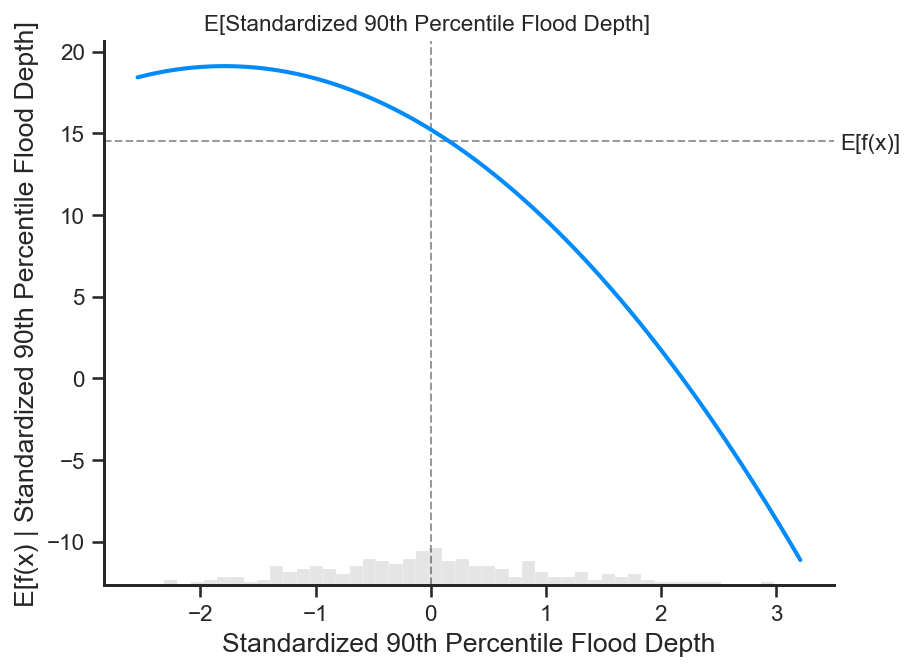

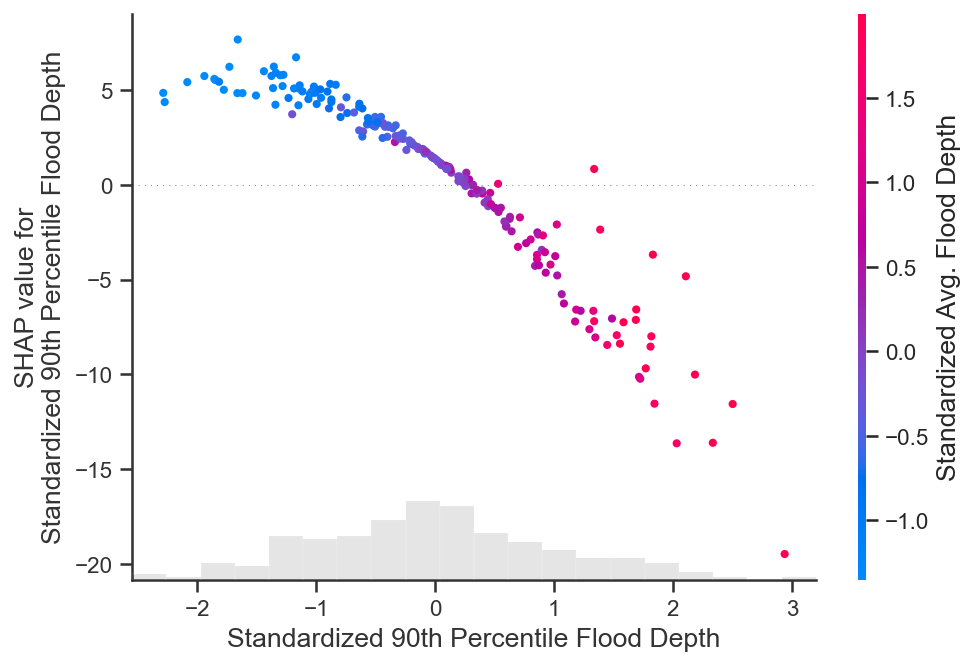

In [93]:
# Now let's look at both the average flood depth and the 90th percentile of the flood depth
# partial dependence plot for average flood depth
shap.partial_dependence_plot(
    'Standardized Avg. Flood Depth', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Now, lets also check out the dependence plot with interactions
shap.plots.scatter(shap_values_ebm[:, "Standardized Avg. Flood Depth"], 
                   color=shap_values_ebm[:,"Standardized 90th Percentile Flood Depth"])
# partial dependence plot for 90th percentile flood depth
shap.partial_dependence_plot(
    'Standardized 90th Percentile Flood Depth', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Now lets look at the dependence plot with interactions
shap.plots.scatter(shap_values_ebm[:, "Standardized 90th Percentile Flood Depth"], 
                   color=shap_values_ebm[:,"Standardized Avg. Flood Depth"])

## Sample scale interpretations

If we want to take the interpretation a step further, we can look at the sample scale influences of each data point on the outcome. This type of analysis can give us an idea of how predictions change across distributions of our features, which enables us to characterize how our model performs in given distinct conditions.

Since tidal amplitude is both an important variable and is a broad environmental variable covering vegetation and hydrologic conditions, let us inspect how our model changes makes predcitions at the 10th, 50th, and 90th percentiles of the tidal amplitude distribution.

In [ ]:
# .... insert the sample scale waterfall plots .... if necessary .... check

# Sources

Molnar, C. (2019). Interpretable machine learning: A guide for making black box models explainable.